In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as opt
import sys

MassPerPart = 2.60809383837199e-20 # solar masses

def load_data(PATH, time_step, num_files):
    for i in range(num_files):
        print('Loading File ' + str(i))
        if i == 0:
            particle_data=np.loadtxt(PATH + 'halos_' + str(time_step) + '.' +\
                                     str(i) + '.particles',
                                     dtype=float, delimiter=' ', comments=['#', '&'])
            ascii_data   =np.loadtxt(PATH + 'halos_' + str(time_step) + '.' + str(i) + '.ascii',
                                     dtype=float, delimiter=' ', comments='#')
        else:
            particle_data_new = np.loadtxt(PATH + 'halos_' + str(time_step) +\
                                           '.' + str(i) + '.particles',
                                           dtype=float, delimiter=' ', comments=['#', '&'])
            ascii_data_new    = np.loadtxt(PATH + 'halos_' + str(time_step) +\
                                           '.' + str(i) + '.ascii',
                                           dtype=float, delimiter=' ', comments='#')
            particle_data = np.concatenate((particle_data, particle_data_new), axis=0)
            ascii_data    = np.concatenate((ascii_data, ascii_data_new), axis=0)

    print("Data Loaded...")
    return particle_data, ascii_data;

def parse_halos(ascii_data):
    halo_nums = ascii_data[:, 1]
    halo_breaks = np.empty(np.size(halo_nums) + 1)
    for i in range(np.size(halo_breaks)):
        halo_breaks[i] = np.sum(halo_nums[:i])
    return halo_breaks;

def get_halo_position(particle_positions):
    x = np.mean(particle_positions[:, 0])
    y = np.mean(particle_positions[:, 1])
    z = np.mean(particle_positions[:, 2])
    return np.array([x, y, z]);
    
def get_separations(particle_positions, halo_position):
    separations = np.zeros(np.shape(particle_positions)[0])
    for i in range(np.shape(particle_positions)[0]):
        separations[i] = np.linalg.norm(particle_positions[i, :] - halo_position)
    return separations;

def get_viable_halos(ascii_data, num_sigma):
    viable_halos = []
    for i in range(int(np.shape(ascii_data)[0])):
        if ascii_data[i, 1] >= np.mean(ascii_data[:, 1]) + num_sigma * np.std(ascii_data[:, 1]):
            viable_halos.append(i)
    return viable_halos;

def model_nfw(r, Rs, rho_0):
    return rho_0 / ((r / Rs) * (1 + (r / Rs))**2);

def model_einasto(r, Rc, rho_e, n):
    return rho_e * np.exp(- 2 * n * ((r / Rc)**(1 / n) - 1));

def get_density_profile(particle_data, ascii_data, halo_breaks, halo_id, N):
    # get data for the halo you chose
    break1 = int(halo_breaks[halo_id])
    break2 = int(halo_breaks[halo_id + 1])
    halo_particles = particle_data[break1:break2, 0:3]
    halo_position  = get_halo_position(halo_particles)
    displacements  = get_separations(halo_particles, halo_position)
    if len(displacements) == 0:
        return np.zeros(N), np.zeros(N), 0.0, 0.0, 0.0;
    radius = np.max(displacements)
    half_mass_radius = ascii_data[halo_id, 48]
    
    fractions = np.linspace(0.22, 1.0, N)
    radial_fractions = fractions * radius 
    # gives an array of 10%, 20%, ..., 90%, 100% of the halo radius
    radial_counts = np.zeros(N)
    for i in range(0, N):
        counts = 0
        for j in range(len(displacements)):
            if displacements[j] <= radial_fractions[i]:
                counts += 1
        radial_counts[i] = counts
    density = radial_counts * MassPerPart / (4 * np.pi * radial_fractions**3 / 3)
    std_density = np.sqrt(radial_counts) * MassPerPart / (4 * np.pi * radial_fractions**3 / 3)
    normalized_counts = radial_counts / len(displacements)
    
    return radial_fractions, density, radius, std_density;

def get_norm_density_profile(particle_data, ascii_data, halo_breaks, halo_id, N):
    # get data for the halo you chose
    break1 = int(halo_breaks[halo_id])
    break2 = int(halo_breaks[halo_id + 1])
    halo_particles = particle_data[break1:break2, 0:3]
    halo_position  = get_halo_position(halo_particles)
    displacements  = get_separations(halo_particles, halo_position)
    if len(displacements) == 0:
        return np.zeros(N), np.zeros(N);
    radius = np.max(displacements)
    half_mass_radius = ascii_data[halo_id, 48]
    
    fractions = np.linspace(0.22, 1.0, N)
    radial_counts = np.zeros(N)
    for i in range(0, N):
        counts = 0
        for j in range(len(displacements)):
            if displacements[j] <= radial_fractions[i]:
                counts += 1
        radial_counts[i] = counts
    norm_radial_counts = radial_counts / len(displacements)
    norm_density = norm_radial_counts / (4 * np.pi * fractions**3 / 3)
    std_density = (np.sqrt(radial_counts) /
                   (4 * np.pi * radial_fractions**3 * len(displacements)/ 3))
    
    return fractions, norm_density;

def get_avg_density_profile(PATH, time_step, num_files):
    particle_data, ascii_data = load_data(PATH, time_step, num_files)
    halo_breaks = parse_halos(ascii_data)
    N = 20
    Nhalos = int(np.shape(ascii_data)[0])
    total_norm_radii = np.zeros([Nhalos, N])
    total_norm_density = np.zeros([Nhalos, N])
    
    for i in range(Nhalos):
        norm_radial_fractions, norm_density = get_norm_density_profile(particle_data, ascii_data, halo_breaks, i, N)
        total_norm_radii[i, :] = norm_radial_fractions
        total_norm_density[i, :] = norm_density
    
    avg_norm_radii, avg_norm_density = np.zeros(N), np.zeros(N)
    std_norm_radii, std_norm_density = np.zeros(N), np.zeros(N)
    for i in range(N):
        avg_norm_radii[i] = np.mean(total_norm_radii[:, i])
        avg_norm_density[i] = np.mean(total_norm_density[:, i])
        std_norm_radii[i] = np.std(total_norm_radii[:, i])
        std_norm_density[i] = np.std(total_norm_density[:, i])
    
    return avg_norm_radii, avg_norm_density, std_norm_radii, std_norm_density;

def plot_density_profile(radial_fractions, density, radius, std_density):
    ics_nfw = np.array([radius, np.mean(density)])
    ics_ein = np.array([radius, np.mean(density), 1.0])
    popt_ein, pcov_ein = opt.curve_fit(model_einasto, radial_fractions,
                                       density, p0=ics_ein, sigma=std_density)
    popt_nfw, pcov_nfw = opt.curve_fit(model_nfw, radial_fractions,
                                       density, p0=ics_nfw, sigma=std_density)
    radial_fit = np.linspace(np.min(radial_fractions), np.max(radial_fractions), 1000)
    ein_fit = model_einasto(radial_fit, popt_ein[0], popt_ein[1], popt_ein[2])
    nfw_fit = model_nfw(radial_fit, popt_nfw[0], popt_nfw[1])
    
    params = {'legend.fontsize': 14,
              'legend.shadow': False}
    plt.rcParams.update(params)
    plt.figure(figsize=(10,7))
    plt.errorbar(radial_fractions, density, fmt='o', yerr=std_density, label='Simulation')
    #plt.plot(radial_fit, ein_fit, '-', label='Einasto Fit')
    plt.plot(radial_fit, nfw_fit, '-', label='NFW Fit')
    plt.xlabel('Radius (Mpc)', fontsize=16, fontname='serif')
    plt.ylabel(r'Density (M$_{\odot}$ / Mpc$^3$)', fontsize=16, fontname='serif')
    plt.title(r'Radial Density Profile',
              fontsize=16, fontname='serif')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()
    return;

In [5]:
PATH = '/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/miniclusters_hires/output/'
N = 20
NSigma = 8

particle_data, ascii_data = load_data(PATH, 26, 1)
halo_breaks = parse_halos(ascii_data)

Loading File 0
Data Loaded...


In [6]:
NSigma = 8
viable_halos = get_viable_halos(ascii_data, NSigma)
print(len(viable_halos))

86


Loading File 0
Data Loaded...
Loading File 0
Data Loaded...
Loading File 0
Data Loaded...


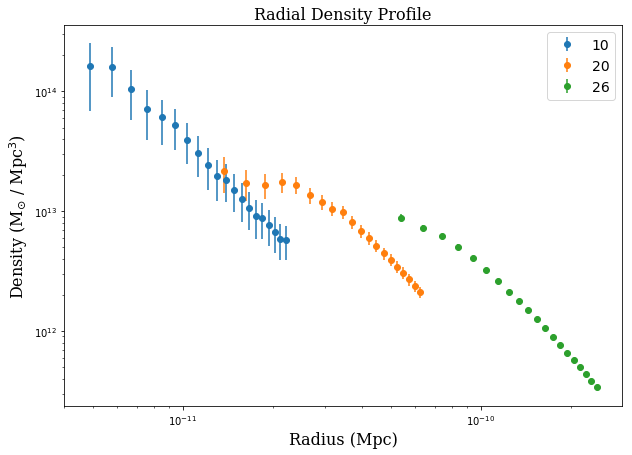

In [9]:
PATH = '/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/miniclusters_hires/output/'
N = 20
NSigma = 8

params = {'legend.fontsize': 14,
          'legend.shadow': False}
plt.rcParams.update(params)
plt.figure(figsize=(10,7))

for i in [10, 20, 26]:
    particle_data, ascii_data = load_data(PATH, i, 1)
    halo_breaks = parse_halos(ascii_data)
    radial_fractions, density, radius, std_density = get_density_profile(particle_data, ascii_data, halo_breaks, 99, 20)
    ics_nfw = np.array([radius, np.mean(density)])
    popt_nfw, pcov_nfw = opt.curve_fit(model_nfw, radial_fractions,
                                       density, p0=ics_nfw, sigma=std_density)
    radial_fit = np.linspace(np.min(radial_fractions), np.max(radial_fractions), 1000)
    nfw_fit = model_nfw(radial_fit, popt_nfw[0], popt_nfw[1])
    plt.errorbar(radial_fractions, density, fmt='o', yerr=std_density, label=str(i))
    
plt.xlabel('Radius (Mpc)', fontsize=16, fontname='serif')
plt.ylabel(r'Density (M$_{\odot}$ / Mpc$^3$)', fontsize=16, fontname='serif')
plt.title(r'Radial Density Profile',
          fontsize=16, fontname='serif')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

Loading File 0
Data Loaded...
Loading File 0
Data Loaded...
Loading File 0
Data Loaded...


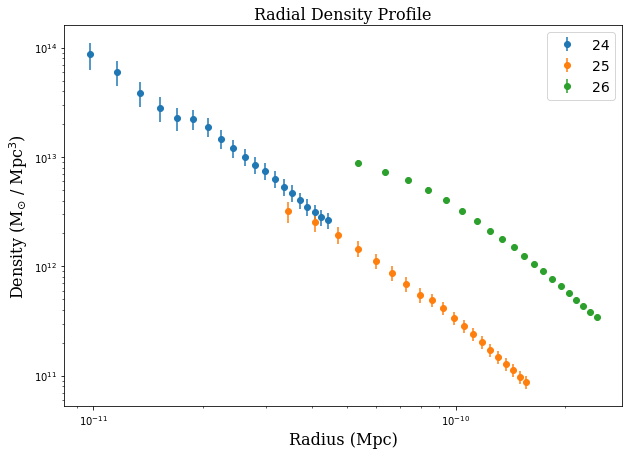

In [10]:
PATH = '/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/miniclusters_hires/output/'
N = 20
NSigma = 8

params = {'legend.fontsize': 14,
          'legend.shadow': False}
plt.rcParams.update(params)
plt.figure(figsize=(10,7))

for i in [24, 25, 26]:
    particle_data, ascii_data = load_data(PATH, i, 1)
    halo_breaks = parse_halos(ascii_data)
    radial_fractions, density, radius, std_density = get_density_profile(particle_data, ascii_data, halo_breaks, 99, 20)
    ics_nfw = np.array([radius, np.mean(density)])
    popt_nfw, pcov_nfw = opt.curve_fit(model_nfw, radial_fractions,
                                       density, p0=ics_nfw, sigma=std_density)
    radial_fit = np.linspace(np.min(radial_fractions), np.max(radial_fractions), 1000)
    nfw_fit = model_nfw(radial_fit, popt_nfw[0], popt_nfw[1])
    plt.errorbar(radial_fractions, density, fmt='o', yerr=std_density, label=str(i))
    
plt.xlabel('Radius (Mpc)', fontsize=16, fontname='serif')
plt.ylabel(r'Density (M$_{\odot}$ / Mpc$^3$)', fontsize=16, fontname='serif')
plt.title(r'Radial Density Profile',
          fontsize=16, fontname='serif')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [3]:
avg_norm_radii = np.linspace(0.22, 1.0, N)
ics_nfw = np.array([1.0, 10.0])
popt_nfw, pcov_nfw = opt.curve_fit(model_nfw, avg_norm_radii,
                                       avg_norm_density, p0=ics_nfw, sigma=std_norm_density)
ics_ein = np.array([np.max(avg_norm_radii), np.max(avg_norm_density), 0.16])
popt_ein, pcov_ein = opt.curve_fit(model_einasto, avg_norm_radii,
                                   avg_norm_density, p0=ics_ein, method='dogbox')
ics_ein = np.array([popt_ein[0], popt_ein[1], popt_ein[2]])
popt_ein, pcov_ein = opt.curve_fit(model_einasto, avg_norm_radii,
                                   avg_norm_density, p0=ics_ein)
radial_fit = np.linspace(np.min(avg_norm_radii), np.max(avg_norm_radii), 1000)
nfw_fit = model_nfw(radial_fit, popt_nfw[0], popt_nfw[1])
ein_fit = model_einasto(radial_fit, popt_ein[0], popt_ein[1], popt_ein[2])
print(popt_nfw)
print(popt_ein)

NameError: name 'N' is not defined